# 1. Install dependencies and setup

In [21]:
!pip install tensorflow opencv-python matplotlib 


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      1.4.0
anyio                        3.7.1
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
cachetools                   5.3.1
caer                         2.0.8
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           2.1.1
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
defusedxml                   0.7.1



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import tensorflow as tf
import os
import shutil

# 2. Remove dodgy images

In [53]:
import cv2
import imghdr

In [54]:
data_directory = 'Data'

In [55]:
#os.listdir(data_directory)

In [56]:
#for image_class in os.listdir(data_directory):
  #  print(image_class)
   # for image in os.listdir(os.path.join(data_directory, image_class)):
    #    print(image)

In [57]:
#img = cv2.imread(os.path.join('data', 'bike', '2023-bmw-r-1250-rs_166842771010.jpg'))
#img.shape
#plt.imshow(img)

In [61]:
image_exists = ['jpeg', 'jpg', 'bmp', 'png']

In [139]:
for image_class in os.listdir(data_directory):
    for image in os.listdir(os.path.join(data_directory, image_class)):
        image_path = os.path.join(data_directory, image_class, image)
        try:
            img = cv2.imread(image_path)
            typ = imghdr.what(image_path)
            if typ not in image_exists:
                print('Image not in the existing list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}: {}'.format(image_path, e))

# 3. Load Data

In [140]:
import numpy as np 
from matplotlib import pyplot as plt

In [155]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 263 files belonging to 2 classes.


In [156]:
data_iterator = data.as_numpy_iterator()

In [157]:
batch = data_iterator.next()

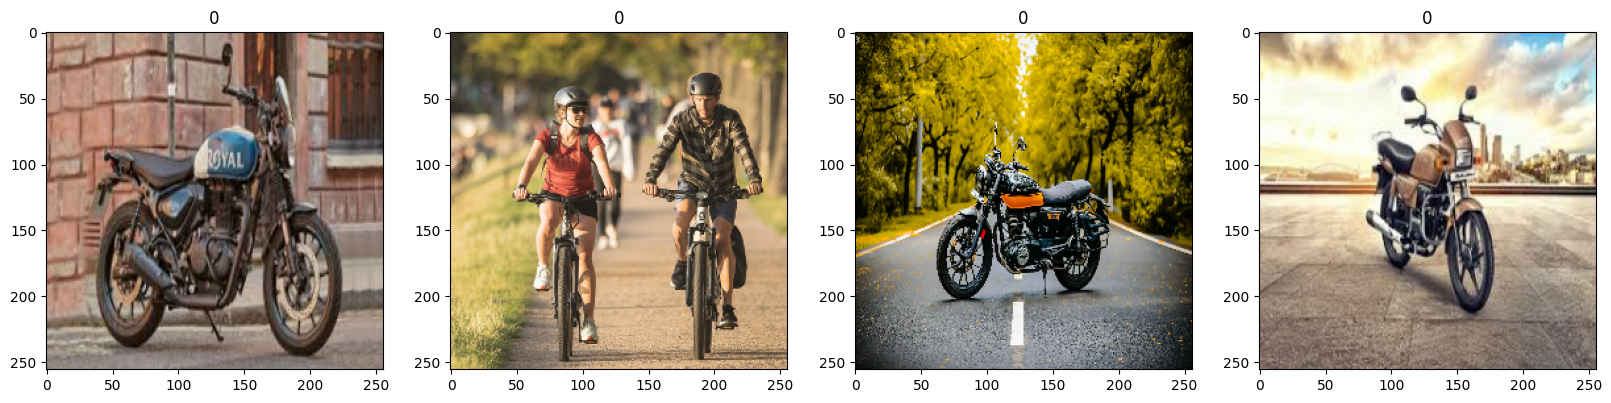

In [158]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [159]:
scaled = batch[0] / 255


In [160]:
scaled.max()

1.0

# 4. Scale Data

In [161]:
#Preprocessing step to normalize pixel values to the range of 0 to 1 
data = data.map(lambda x, y: (x/255, y))

In [162]:
scaled_iterator = data.as_numpy_iterator()

In [163]:
batch = scaled_iterator.next()

In [164]:
batch[0].max()

1.0

# 5. Split Data

In [165]:
len(data)

9

In [166]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.3)
test_size = int(len(data)*.2)

In [167]:
train_size+val_size+test_size

9

# 6. Build Deep Learning Model

In [168]:
train

NameError: name 'train' is not defined

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [106]:
model = Sequential()

model.add(Conv2D(16, (3,3),1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu')) 
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))          
model.add(MaxPooling2D()) 
model.add(Flatten())
model.add(Dense(256, activation='relu'))          
model.add(Dense(1, activation='sigmoid'))          

In [110]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy, metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 16)        4

# 7. Train the model

In [127]:
logdir='logs'

In [134]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [135]:
hist = model.fit(training, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

NameError: name 'training' is not defined